In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset

# 1️⃣ Load dataset
dataset = load_dataset("json", data_files={"train": "test_fine_tune.json", "test": "test_fine_tune.json"}, field="train")

# 2️⃣ Load tokenizer and model
model_name = "facebook/bart-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 3️⃣ Preprocessing
def preprocess(examples):
    return tokenizer(examples['premise'], examples['hypothesis'], truncation=True, padding=True)

dataset = dataset.map(preprocess, batched=True)

# 4️⃣ Remove unused columns for Trainer
dataset = dataset.remove_columns(["premise", "hypothesis"])

# 5️⃣ Fine-tuning with Trainer
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    save_steps=500,
    logging_steps=50,
    learning_rate=2e-5,
    save_total_limit=2,
    push_to_hub=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"]
)

trainer.train()

# 6️⃣ Test fine-tuned model with zero-shot pipeline
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model=model, tokenizer=tokenizer)

test_texts = [
    "I am looking for a product for my child",
    "I want to adopt a cat",
    "I need assistance for a disabled person",
    "I just want something else"
]

candidate_labels = ["child", "handicap", "pet", "other"]

for text in test_texts:
    result = classifier(text, candidate_labels)
    print(f"\nText: {text}")
    print("Predicted class:", result['labels'][0])
    print("Scores:", result['scores'])


c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

# Jeu de données

In [3]:
import pandas as pd

# Charger les datasets
df_keywords = pd.read_csv("key_words_data_accessiblego.csv")  # contient id, review, keywords_found, category
df_data = pd.read_csv("data_accessiblego.csv")          # contient id, review

# Choisir la catégorie
category_to_filter = "handicap"  # remplace par la catégorie souhaitée

# Filtrer sur la catégorie
filtered_ids = df_keywords[df_keywords["category"] == category_to_filter]["id"]

# Récupérer les reviews correspondantes dans data.csv
reviews_filtered = df_data[df_data["id"].isin(filtered_ids)]

reviews_only = reviews_filtered[["review"]]


# Exporter dans un CSV
reviews_only.to_csv("filtered_reviews_handicap_accessiblego.csv", index=False, header=False)



## Test

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler, GPT2Tokenizer
from sklearn.metrics import f1_score
from tqdm.auto import tqdm
from torch.optim import AdamW

# ==== PARAMÈTRES ====
MODEL_NAME = "microsoft/deberta-v3-base"  
NUM_LABELS = 4  # adapte selon ton dataset
BATCH_SIZE = 2
EPOCHS = 3
LR = 2e-5
MAX_LEN = 512  

# ==== DATA ====
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("finetune_dataset.csv")

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Hugging Face dataset
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token 

def tokenize(batch):
    return tokenizer(batch["review"], padding="max_length", truncation=True, max_length=MAX_LEN)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

# PyTorch format
label_cols = ["handicap", "pet", "child", "other"]

train_ds.set_format("torch", columns=["input_ids", "attention_mask"] + label_cols)
val_ds.set_format("torch", columns=["input_ids", "attention_mask"] + label_cols)
test_ds.set_format("torch", columns=["input_ids", "attention_mask"] + label_cols)

# ==== MODEL ====
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# ==== TRAIN ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)
num_training_steps = EPOCHS * len(train_ds)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

def sigmoid(x): return 1 / (1 + torch.exp(-x))

def compute_f1(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(int)
    return f1_score(y_true, y_pred, average="micro")

model.train()
for epoch in range(EPOCHS):
    loop = tqdm(DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True))
    for batch in loop:
        labels = torch.stack([batch[col] for col in label_cols], dim=1).float().to(device)
        inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

# ==== EVAL ====
model.eval()
preds, trues = [], []
for batch in DataLoader(val_ds, batch_size=BATCH_SIZE):
    labels = torch.stack([batch[col] for col in label_cols], dim=1).float().to(device)
    inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
    with torch.no_grad():
        logits = model(**inputs).logits
    preds.append(sigmoid(logits.cpu()).numpy())
    trues.append(labels)

import numpy as np
f1 = compute_f1(np.vstack(trues), np.vstack(preds))
print("Validation F1:", f1)


Map:   0%|          | 0/66 [00:00<?, ? examples/s]

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/17 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Exception ignored in: <function tqdm.__del__ at 0x000002EA89D21940>
Traceback (most recent call last):
  File "c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


KeyboardInterrupt: 

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler, DebertaV2Tokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.auto import tqdm
from torch.optim import AdamW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ==== PARAMÈTRES ====
MODEL_NAME = "microsoft/deberta-v3-base"
NUM_LABELS = 4
BATCH_SIZE = 2
EPOCHS = 3
LR = 2e-5
MAX_LEN = 128
label_cols = ["handicap", "pet", "child", "other"]

# ==== DATA ====
df = pd.read_csv("finetune_dataset.csv").sample(n=50, random_state=42)

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

# ==== TOKENIZER ====

tokenizer = DebertaV2Tokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["review"], padding="max_length", truncation=True, max_length=MAX_LEN)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask"] + label_cols)
val_ds.set_format("torch", columns=["input_ids", "attention_mask"] + label_cols)
test_ds.set_format("torch", columns=["input_ids", "attention_mask"] + label_cols)

# ==== MODEL ====
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# ==== DEVICE ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ==== OPTIMIZER + SCHEDULER ====
optimizer = AdamW(model.parameters(), lr=LR)
num_training_steps = EPOCHS * len(train_ds) // BATCH_SIZE
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# ==== FONCTION D'ÉVALUATION ====
def evaluate(model, dataset, label_cols, batch_size=4, device="cpu"):
    model.eval()
    preds, trues = [], []
    for batch in DataLoader(dataset, batch_size=batch_size):
        labels = torch.stack([batch[col] for col in label_cols], dim=1).numpy()
        inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = torch.sigmoid(logits).cpu().numpy()
        preds.append(probs)
        trues.append(labels)
    
    preds = np.vstack(preds)
    trues = np.vstack(trues)
    preds_bin = (preds > 0.3).astype(int)

    metrics = {
        "accuracy": accuracy_score(trues, preds_bin),
        "precision": precision_score(trues, preds_bin, average="micro", zero_division=0),
        "recall": recall_score(trues, preds_bin, average="micro", zero_division=0),
        "f1": f1_score(trues, preds_bin, average="micro", zero_division=0)
    }
    return metrics

# ==== ÉVALUATION AVANT FINE-TUNING ====
print("=== Évaluation avant fine-tuning ===")
pretrain_metrics = evaluate(model, val_ds, label_cols, batch_size=BATCH_SIZE, device=device)
for k, v in pretrain_metrics.items():
    print(f"{k}: {v:.4f}")

# ==== TRAIN + SUIVI DES MÉTRIQUES ====
history = {"loss": [], "accuracy": [], "precision": [], "recall": [], "f1": []}

for epoch in range(EPOCHS):
    model.train()
    loop = tqdm(DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True))
    running_loss = 0
    for batch in loop:
        labels = torch.stack([batch[col] for col in label_cols], dim=1).float().to(device)
        inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

    # Moyenne de la perte sur l'epoch
    avg_loss = running_loss / len(loop)

    # Évaluation sur validation
    metrics = evaluate(model, val_ds, label_cols, batch_size=BATCH_SIZE, device=device)

    history["loss"].append(avg_loss)
    history["accuracy"].append(metrics["accuracy"])
    history["precision"].append(metrics["precision"])
    history["recall"].append(metrics["recall"])
    history["f1"].append(metrics["f1"])

    print(f"Epoch {epoch} - Loss: {avg_loss:.4f} | Acc: {metrics['accuracy']:.4f} | "
          f"Prec: {metrics['precision']:.4f} | Rec: {metrics['recall']:.4f} | F1: {metrics['f1']:.4f}")

# ==== PLOT DES MÉTRIQUES ====
plt.figure(figsize=(12,6))
plt.plot(range(EPOCHS), history["loss"], label="Loss")
plt.plot(range(EPOCHS), history["accuracy"], label="Accuracy")
plt.plot(range(EPOCHS), history["precision"], label="Precision")
plt.plot(range(EPOCHS), history["recall"], label="Recall")
plt.plot(range(EPOCHS), history["f1"], label="F1")
plt.xlabel("Epoch")
plt.ylabel("Valeur")
plt.title("Évolution des métriques pendant le fine-tuning")
plt.legend()
plt.show()

# ==== ÉVALUATION FINALE APRÈS FINE-TUNING ====
print("\n=== Évaluation finale après fine-tuning ===")
final_metrics = evaluate(model, val_ds, label_cols, batch_size=BATCH_SIZE, device=device)
for k, v in final_metrics.items():
    print(f"{k}: {v:.4f}")


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


=== Évaluation avant fine-tuning ===


Exception ignored in: <function tqdm.__del__ at 0x0000018695B59800>
Traceback (most recent call last):
  File "c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


accuracy: 0.0000
precision: 0.2500
recall: 1.0000
f1: 0.4000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 - Loss: 0.6525 | Acc: 0.0000 | Prec: 0.2500 | Rec: 1.0000 | F1: 0.4000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 - Loss: 0.5877 | Acc: 0.0000 | Prec: 0.2667 | Rec: 0.8000 | F1: 0.4000


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
batch = next(iter(DataLoader(val_ds, batch_size=4)))
inputs = {k: v.to(device) for k,v in batch.items() if k in ["input_ids","attention_mask"]}
labels = torch.stack([batch[col] for col in label_cols], dim=1)
with torch.no_grad():
    logits = model(**inputs).logits
probs = torch.sigmoid(logits).cpu().numpy()
print("Probs:", probs)
print("Labels:", labels)


Probs: [[0.2139775  0.3614397  0.26746103 0.2835042 ]
 [0.20355363 0.3627451  0.2876741  0.2838162 ]
 [0.21516015 0.37406728 0.2520137  0.2873677 ]
 [0.27090776 0.37614912 0.2789748  0.29411465]]
Labels: tensor([[0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]])


## LoRA

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== Évaluation avant fine-tuning ===


Exception ignored in: <function tqdm.__del__ at 0x0000021C58339760>
Traceback (most recent call last):
  File "c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


accuracy: 0.0000
precision: 0.2273
recall: 0.5128
f1: 0.3150


  0%|          | 0/143 [00:00<?, ?it/s]

Epoch 0 - Loss: 0.6845 | Acc: 0.0556 | Prec: 0.2424 | Rec: 0.2051 | F1: 0.2222


  0%|          | 0/143 [00:00<?, ?it/s]

Epoch 1 - Loss: 0.6428 | Acc: 0.0556 | Prec: 0.4000 | Rec: 0.0513 | F1: 0.0909


  0%|          | 0/143 [00:00<?, ?it/s]

Epoch 2 - Loss: 0.6286 | Acc: 0.0278 | Prec: 0.3333 | Rec: 0.0256 | F1: 0.0476


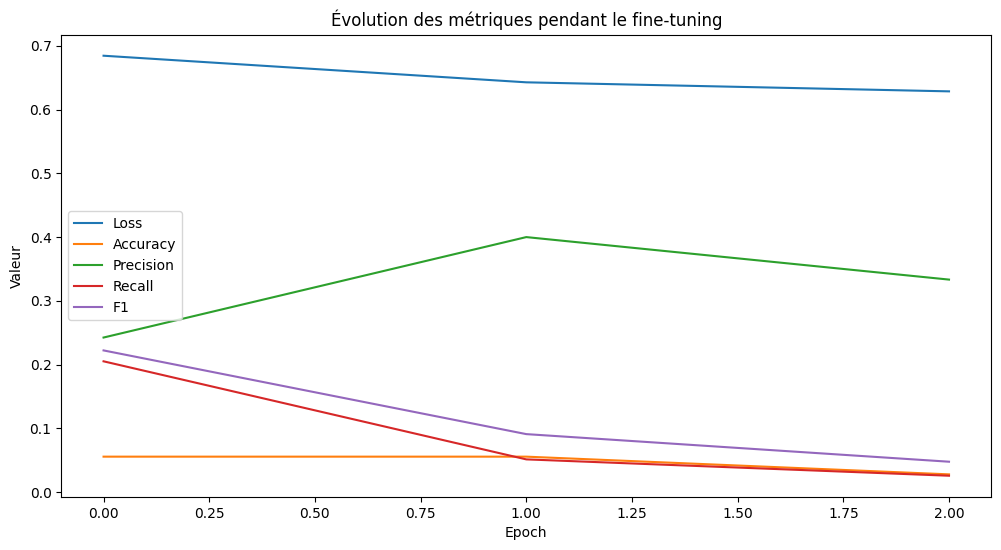


=== Évaluation finale après fine-tuning ===
accuracy: 0.0278
precision: 0.3333
recall: 0.0256
f1: 0.0476


In [14]:
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler, GPT2Tokenizer
from peft import LoraConfig, get_peft_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from torch.optim import AdamW
import matplotlib.pyplot as plt

# ==== PARAMÈTRES ====
MODEL_NAME = "microsoft/deberta-v3-base"
NUM_LABELS = 4
BATCH_SIZE = 2
EPOCHS = 3
LR = 2e-5
MAX_LEN = 256
label_cols = ["handicap", "pet", "child", "other"]

# ==== DATA ====
df = pd.read_csv("finetune_dataset.csv")
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

# ==== TOKENIZER ====
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

def tokenize(batch):
    return tokenizer(batch["review"], padding="max_length", truncation=True, max_length=MAX_LEN)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask"] + label_cols)
val_ds.set_format("torch", columns=["input_ids", "attention_mask"] + label_cols)
test_ds.set_format("torch", columns=["input_ids", "attention_mask"] + label_cols)

# ==== MODEL LoRA ====
base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=None,  # détecte automatiquement les bonnes couches
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(base_model, lora_config)

# ==== DEVICE ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ==== OPTIMIZER + SCHEDULER ====
optimizer = AdamW(model.parameters(), lr=LR)
num_training_steps = EPOCHS * len(train_ds) // BATCH_SIZE
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# ==== FONCTION D'ÉVALUATION ====
def evaluate(model, dataset, label_cols, batch_size=4, device="cpu"):
    model.eval()
    preds, trues = [], []
    for batch in DataLoader(dataset, batch_size=batch_size):
        labels = torch.stack([batch[col] for col in label_cols], dim=1).numpy()
        inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = torch.sigmoid(logits).cpu().numpy()
        preds.append(probs)
        trues.append(labels)
    
    preds = np.vstack(preds)
    trues = np.vstack(trues)
    preds_bin = (preds > 0.5).astype(int)

    metrics = {
        "accuracy": accuracy_score(trues, preds_bin),
        "precision": precision_score(trues, preds_bin, average="micro", zero_division=0),
        "recall": recall_score(trues, preds_bin, average="micro", zero_division=0),
        "f1": f1_score(trues, preds_bin, average="micro", zero_division=0)
    }
    return metrics

# ==== ÉVALUATION AVANT FINE-TUNING ====
print("=== Évaluation avant fine-tuning ===")
pretrain_metrics = evaluate(model, val_ds, label_cols, batch_size=BATCH_SIZE, device=device)
for k, v in pretrain_metrics.items():
    print(f"{k}: {v:.4f}")

# ==== TRAIN + SUIVI DES MÉTRIQUES ====
history = {"loss": [], "accuracy": [], "precision": [], "recall": [], "f1": []}

for epoch in range(EPOCHS):
    model.train()
    loop = tqdm(DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True))
    running_loss = 0
    for batch in loop:
        labels = torch.stack([batch[col] for col in label_cols], dim=1).float().to(device)
        inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

    # Moyenne de la loss sur l'epoch
    avg_loss = running_loss / len(loop)
    
    # Évaluation sur validation
    metrics = evaluate(model, val_ds, label_cols, batch_size=BATCH_SIZE, device=device)

    history["loss"].append(avg_loss)
    history["accuracy"].append(metrics["accuracy"])
    history["precision"].append(metrics["precision"])
    history["recall"].append(metrics["recall"])
    history["f1"].append(metrics["f1"])

    print(f"Epoch {epoch} - Loss: {avg_loss:.4f} | Acc: {metrics['accuracy']:.4f} | "
          f"Prec: {metrics['precision']:.4f} | Rec: {metrics['recall']:.4f} | F1: {metrics['f1']:.4f}")

# ==== PLOT DES MÉTRIQUES ====
plt.figure(figsize=(12,6))
plt.plot(range(EPOCHS), history["loss"], label="Loss")
plt.plot(range(EPOCHS), history["accuracy"], label="Accuracy")
plt.plot(range(EPOCHS), history["precision"], label="Precision")
plt.plot(range(EPOCHS), history["recall"], label="Recall")
plt.plot(range(EPOCHS), history["f1"], label="F1")
plt.xlabel("Epoch")
plt.ylabel("Valeur")
plt.title("Évolution des métriques pendant le fine-tuning")
plt.legend()
plt.show()

# ==== ÉVALUATION FINALE APRÈS FINE-TUNING ====
print("\n=== Évaluation finale après fine-tuning ===")
final_metrics = evaluate(model, val_ds, label_cols, batch_size=BATCH_SIZE, device=device)
for k, v in final_metrics.items():
    print(f"{k}: {v:.4f}")
